In [4]:
data_path = '/home/mike/Data/boeing/tominta'
data_path = '/home/mike/Data/boeing/tominta/more_data_from_britton'
data_path = "/Users/mike/Data/boeing/tomita"


import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools


project = signac.get_project(data_path)
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
df = pd.DataFrame(statepoints).T.join(df_index)
df = df.sort_values('T')

In [5]:
def get_custom_ranges(cooling_method):
    if cooling_method=='quench':
        custom_ranges_l1={20.0:[0.4,0.6],
                          30.0:[0.4,0.6],
                          40.0:[0.4,0.6],
                          50.0:[0.4,0.6],
                          60.0:[0.4,0.6],
                          80.0:[0.4,0.6]}
        custom_ranges_l2={20.0:[0.8,1.1],
                          30.0:[0.8,0.9],
                          40.0:[0.8,1.0],
                          50.0:[0.9,1.1],
                          60.0:[0.9,1.2],
                          80.0:[0.9,1.3]}
        
        custom_ranges_l1={20.0:[0.1,0.6],
                         30.0:[0.1,0.6],
                         40.0:[0.1,0.6],
                         60.0:[0.1,0.6],
                         80.0:[0.1,0.6]}
        custom_ranges_l2={20.0:[0.62,0.67],#0.06
                         40.0:[0.64,0.70],#0.06
                         60.0:[0.67,0.77],#0.10
                         80.0:[0.69,0.89]}#0.20
    elif cooling_method=='anneal':
        custom_ranges_l1={00.0:[0.1,0.8],
                          30.0:[0.1,0.8],
                          50.0:[0.1,0.8],
                          70.0:[0.1,0.8]}
        custom_ranges_l2={00.0:[0.7,1.2],
                          30.0:[0.85,1.4],
                          50.0:[1.0,1.8],
                          70.0:[1.15,2.5]}
    else:
        raise ValueError(cooling_method+'is unknown')
    return custom_ranges_l1, custom_ranges_l2

[0.1, 0.6]


/Users/mike/miniconda3/envs/epoxpy_analysis/lib/python3.6/site-packages/piecewise/regressor.py:323: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeffs, error = np.linalg.lstsq(A.T, v_slice)[0:2]


[0.1, 0.6]
[0.1, 0.6]
[0.1, 0.6]


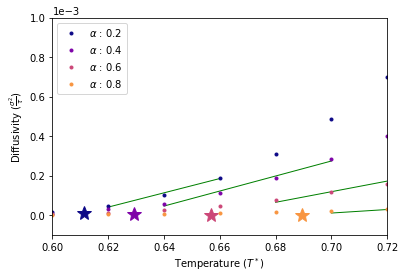

In [6]:
import matplotlib
from common import Fit_Diffusivity1, getDiffusivities
%matplotlib inline
from piecewise.regressor import piecewise #https://www.datadoghq.com/blog/engineering/piecewise-regression/
from piecewise.plotter import plot_data_with_regression
PROP_NAME ='bparticles'#'volume'#'pair_lj_energy','bond_harmonic_energy'#'potential_energy'
filter_saps=[10,40, 80]#,100.]#,100.]#[0.0,50.0,100.0]#,30,50,70]#,90]
filter_saps=[20,30, 40, 80]#,100.]#,100.]#[0.0,50.0,100.0]#,30,50,70]#,90]
filter_saps=[0,10, 20,40, 60, 80]
filter_saps=[20, 40, 60, 80]

colors = plt.cm.plasma(np.linspace(0,0.75,len(filter_saps)))
Tgs=[]
Tgs_tangent=[]
cure_percents = []
Cure_Ts=[]
markers=['+','.']
markersize=[10,10]
cooling_method='quench'

df_filtered=df[(df.quench_T<=1.3)&
               (df.quench_T>=0)&
               (df.cooling_method==cooling_method)]#(df.quench_T<=3.0)&(df.quench_T>=0.05)&
for i,sap in enumerate(filter_saps):
    cooling_colors = plt.cm.plasma(np.linspace(0,0.75,2))
    for j,(cooling_method,df_grp) in enumerate(df_filtered.groupby('cooling_method')):
        df_curing = df_grp[(df_grp.bond==False)&
                       (df_grp.calibrationT==305)&
                       (df_grp.cooling_method==cooling_method)&
                       (df_grp.stop_after_percent==sap)]
        cure_percent = df_curing.cure_percent.mean()
        cure_percents.append(cure_percent)
        Ts,Ds=getDiffusivities(project,df_curing,name=PROP_NAME)
        Cure_Ts.append(Ts)
        
        mul_fact=1000000
        Ds_scaled=Ds*mul_fact
        custom_ranges_l1, custom_ranges_l2 = get_custom_ranges(cooling_method)
        print(custom_ranges_l1[sap])
        Tg,Tg_prop,line_vals = Fit_Diffusivity1(Ts,
                                  Ds_scaled,
                                  method='use_viscous_region',
                                  min_D=0,
                                  ver=4,
                                  viscous_line_index=0,
                                  l1_T_bounds=custom_ranges_l1[sap],
                                  l2_T_bounds=custom_ranges_l2[sap])
        xs = Ts#np.linspace(0.1,4)
        plt.plot(Tg,
                 Tg_prop/mul_fact,
                 marker='*',
                 color=colors[i],
                 markersize=15)#,
                    
        plt.plot(Ts,
                 Ds,
                 marker='.',
                 color=colors[i],#cooling_colors[j],
                 linewidth=0.0,
                 label='$\\alpha$ : {:.1f}'.format(sap/100))

        
        #l_colors = plt.cm.coolwarm(np.linspace(0,0.75,len(line_vals)))
        l_colors=['r','g']
        for li,line_val in enumerate(line_vals):
            xs=line_val[0]
            ys=line_val[1]/mul_fact
            plt.plot(xs,
                     ys,
                     color=l_colors[li],
                     zorder=0,
                     linewidth=1)
        Tgs.append(Tg)
    #break
plt.legend(fontsize=10)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
Tgs = np.asarray(Tgs)
cure_percents = np.asarray(cure_percents)
data=[cure_percents,Tgs]
plt.xlim(0.6,0.72)
plt.ylim(-1e-4, 0.1e-2)
plt.xlabel('Temperature ($T^*$)')
plt.ylabel('Diffusivity ($\\frac{\\sigma^2}{\\tau}$)')
#savefig(plt,'piecewise_regression_custom_range','all_alphas_zoomed.pdf')
#savefig(plt,'piecewise_regression_custom_range','all_alphas.pdf')
#np.savetxt('piecewise_regression_custom_range/Tg_{}.txt'.format(cooling_method),np.transpose(data))

plt.show()

[0.61148476 0.62921715 0.65691316 0.68942752]
[20. 40. 60. 80.]
[0.61148476 0.62921715 0.65691316 0.68942752]
T1 0.736924840635899 lambda 0.5
T0 0.5951377662133829 lambda 0.5
300 K in T*: 0.4605780253974369


'\n[0.67262141 0.74255643 0.82686872]\n[10. 40. 80.]\n[0.67262141 0.74255643 0.82686872]\nT1 0.9122632990898161 lambda 0.5\n300 K in T*: 0.5701645619311351\n'

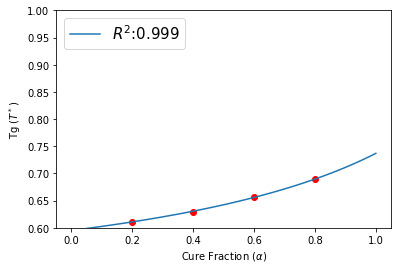

In [7]:
from common import fit_Tg_to_DiBenedetto, DiBenedetto
cure_percents = np.asarray(cure_percents)
#Tgs=[0.65,0.75,0.9,2.1]
fig, ax1 = plt.subplots()
#ax2=ax1.twinx()
Tgs = np.asarray(Tgs)
Tgs_tangent = np.asarray(Tgs_tangent)
print(Tgs)
Tg_data = np.asarray([cure_percents/100.,Tgs])
cure_percents_ss = cure_percents#[:-1]
Tgs_ss = Tgs#[:-1]
print(cure_percents_ss)
print(Tgs_ss)
R2,fit_Tgs,T1,inter_parm,T0 = fit_Tg_to_DiBenedetto(cure_percents_ss/100.,
                                                 Tgs_ss,
                                                 T1=None,
                                                 T0=None)
print('T1',T1,'lambda',inter_parm)
print('T0',T0,'lambda',inter_parm)
alphas = np.linspace(0,1)
fit_ydata = DiBenedetto(alphas,T1,T0=T0,inter_param=inter_parm)
ax1.plot(alphas,fit_ydata,label='$R^2$:{}'.format(round(R2,3)))
ax1.scatter(cure_percents/100.,
            Tgs,
            color='r')

Tg_sim = T1#0.851796418313
Tg_exp = 480
roomT_exp = 300
Tex_toTsim = Tg_exp/Tg_sim
roomT_sim =  Tg_sim*roomT_exp/Tg_exp
Tg0_exp = Tg_exp*T0/Tg_sim
print('300 K in T*:',roomT_sim)
#ax2.scatter(1.00,Tg_exp,marker='*',color='r',s=200,label='Experimental Tg ($\\alpha=1.0$)')
#ax2.set_ylabel('Tg (K)')

sim_low_lim = 0.6
ex_low_lim = sim_low_lim*Tex_toTsim
sim_up_lim = 1.0
ex_up_lim = sim_up_lim*Tex_toTsim
#ax2.set_ylim(ex_low_lim,ex_up_lim)
ax1.set_ylim(sim_low_lim,sim_up_lim)
#ax1.set_ylim(0,3)
show_roomT=True
#if show_roomT:
#    ax1.axhline(y=roomT_sim,linewidth=1.1,linestyle='--',label='simulated 300 K')
ax1.set_xlabel('Cure Fraction ($\\alpha$)')
ax1.set_ylabel('Tg ($T^*$)')
ax1.legend(fontsize=15,loc='upper left')
#ax2.legend(fontsize=15,loc='lower right')
plt.ticklabel_format(axis='y',style='plain')
#savefig(plt,'piecewise_regression_custom_range','dibeneditto.pdf')
'''
[0.67262141 0.74255643 0.82686872]
[10. 40. 80.]
[0.67262141 0.74255643 0.82686872]
T1 0.9122632990898161 lambda 0.5
300 K in T*: 0.5701645619311351
'''